In [48]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

# Dados sintéticos
X = np.random.rand(5000, 10) * 2 - 1  # 5000 exemplos, 10 características
y = (X.sum(axis=1) > 0).astype(int)  # Classe 1 se a soma das características for positiva

# Convertendo para tensores
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Criando dataset e dividindo em treino/validação
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [49]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(10, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [52]:
# Instanciando o modelo
model = SimpleNN()

# Definindo otimizadores
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
sgd_optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)

# Definindo scheduler para SGD
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(sgd_optimizer, step_size=10, gamma=0.1)

In [56]:
criterion = nn.CrossEntropyLoss(reduction='mean')

# Função de treino
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Função de validação
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Inicializando listas para armazenar perdas
train_losses = []
val_losses = []

# Loop de treinamento
epochs = 90
for epoch in range(epochs):
    if epoch < 45:
        # Usando Adam nas primeiras 45 épocas
        train_loss = train(model, train_loader, adam_optimizer, criterion)
    else:
        # Usando SGD nas últimas 45 épocas com scheduler
        train_loss = train(model, train_loader, sgd_optimizer, criterion)
        step_lr_scheduler.step()

    val_loss = validate(model, val_loader, criterion)

    # Armazenando as perdas
    train_losses.append(train_loss)
    val_losses.append(val_loss)

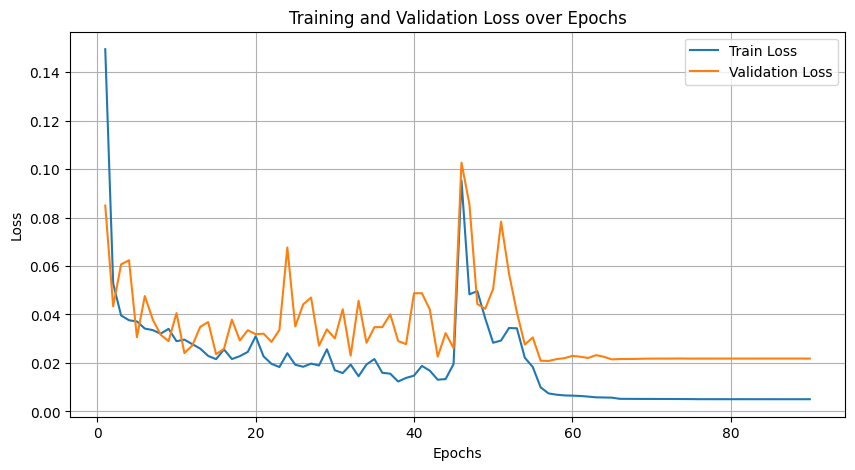

In [54]:
# Plotando as perdas de treinamento e validação
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()